# Import Packages and Construct Bitome

In [17]:
from collections import Counter
from pathlib import Path
import re
import sys

import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
import pandas as pd
from pymodulon.io import load_json_model
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

sys.path.append('../../bitome2')

from bitome.core import Bitome
from bitome.ml import *
from bitome.util import score_motif_match

In [18]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [19]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)

In [20]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [21]:
mg1655.gene_table.head()

,left,right,strand,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm
locus_tag,,,,,,,,,,,,,
b0001,190,255,1,False,thrL,NaN,NaN,well-annotated,NaN,NaN,NaN,unknown,NaN
b0002,337,2799,1,False,thrA,E,NaN,well-annotated,911.871207,1272.481486,663.451039,unknown,9.834268
b0003,2801,3733,1,False,thrB,E,NaN,well-annotated,771.705903,1010.478960,576.611751,unknown,9.593776
b0004,3734,5020,1,False,thrC,E,NaN,well-annotated,693.743865,1004.478234,530.762368,repressed,9.440337
b0005,5234,5530,1,False,yaaX,NaN,NaN,y-ome,74.792947,139.310756,80.723833,unknown,6.243992


# Load P1K Log2[TPM]

In [22]:
p1k = load_json_model('../data/p1k/precise1k.json.gz')
p1k_log_tpm = pd.read_csv('../data/p1k/log_tpm_qc_w_short_low_fpkm.csv', index_col=0)
p1k_gene_table = pd.read_csv('../data/p1k/gene_info.csv', index_col=0)

In [23]:
combined_gene_table = p1k_gene_table[['synonyms', 'gene_product', 'gene_name', 'regulator', 'DGF_strain', 'in_iM']].merge(
    mg1655.gene_table[['left', 'right', 'strand', 'cog', 'essential', 'reg_effect']],
    left_index=True, right_index=True, how='left'
)

In [24]:
# create a copy of the log_tpm table that has entries removed for genes that are explicitly KO'ed
# also want to ignore all ALEs for these purposes to avoid deletion effects
log_tpm_no_ko = p1k_log_tpm.copy()
combined_gene_table = combined_gene_table.loc[log_tpm_no_ko.index]

for p1k_id, strain_desc in p1k.sample_table['Strain Description'].items():
    kos = [sub_str.split('del_')[1] for sub_str in strain_desc.split(' ') if 'del_' in sub_str]
    ko_idx = set(combined_gene_table[combined_gene_table['gene_name'].isin(kos)].index).intersection(set(log_tpm_no_ko.index))
    log_tpm_no_ko.loc[list(ko_idx), p1k_id] = None
    
# also need to account for the minicoli deletions
minicoli_p1k_ids = p1k.sample_table[p1k.sample_table['Strain Description'].str.contains('DGF')].index
minicoli_gene_kos = combined_gene_table[combined_gene_table['DGF_strain'] == False].index
log_tpm_no_ko.loc[minicoli_gene_kos, minicoli_p1k_ids] = None

# also remove the overexpressions of MalE
log_tpm_no_ko.loc['b4034', ['p1k_00666', 'p1k_00667']] = None

# add some columns to gene table with summary stats - have to be cautious that we have 
combined_gene_table = combined_gene_table.assign(
    median_log_tpm=log_tpm_no_ko.median(axis=1),
    # this function doesn't nicely drop NAs automatically like the native DataFrame methods
    mad_log_tpm=log_tpm_no_ko.apply(lambda row: median_abs_deviation(row.dropna()), axis=1),
    pct10_log_tpm=log_tpm_no_ko.apply(lambda row: np.percentile(row, 10), axis=1),
    pct25_log_tpm=log_tpm_no_ko.apply(lambda row: np.percentile(row, 25), axis=1),
    max_log_tpm=log_tpm_no_ko.max(axis=1),
    min_log_tpm=log_tpm_no_ko.min(axis=1),
    mean_log_tpm=log_tpm_no_ko.mean(axis=1),
    skew=log_tpm_no_ko.skew(axis=1)
)

# add in our LOW cutoffs
median_cutoff = 2

# compute inducibility metrics
combined_gene_table = combined_gene_table.assign(
    range_log_tpm=(combined_gene_table['max_log_tpm'] - combined_gene_table['min_log_tpm']),
    max_to_median=(combined_gene_table['max_log_tpm'] - combined_gene_table['median_log_tpm']),
    min_to_median=(combined_gene_table['min_log_tpm'] - combined_gene_table['median_log_tpm']),
    low=combined_gene_table.apply(lambda row: row['median_log_tpm'] < median_cutoff, axis=1)
)

# determine complexes; do this crudely based on same TU/same gene prefix
def in_complex(bnum):
    co_tu_genes = []
    for tu in mg1655._gene_to_tus[bnum]:
        co_tu_genes.extend(mg1655._tu_to_genes[tu])
    co_tu_gene_names = [p1k_gene_table.loc[bn, 'gene_name'] for bn in co_tu_genes if bn in p1k_gene_table.index]
    complex_prefixes = [k for k, v in Counter([name[:3] for name in co_tu_gene_names]).items() if v > 1]
    return p1k_gene_table.loc[bnum, 'gene_name'][:3] in complex_prefixes
combined_gene_table = combined_gene_table.assign(
    in_complex=pd.Series(combined_gene_table.index).apply(in_complex).values
)

combined_gene_table.head()

,synonyms,gene_product,gene_name,regulator,DGF_strain,in_iM,left,right,strand,cog,...,pct25_log_tpm,max_log_tpm,min_log_tpm,mean_log_tpm,skew,range_log_tpm,max_to_median,min_to_median,low,in_complex
b0001,thrL,thr operon leader peptide,thrL,NaN,True,False,190.0,255.0,1.0,NaN,...,7.633022,14.327388,0.000000,9.079599,0.248526,14.327388,5.465045,-8.862343,False,True
b0002,thrA;thrA1;thrA2,fused aspartate kinase/homoserine dehydrogenase 1,thrA,"RpoD,Ile-tRNA,Thr-tRNA,DksA,Fnr,ArcA,ppGpp",True,True,337.0,2799.0,1.0,E,...,8.701393,11.771901,0.000000,9.268791,-1.946621,11.771901,2.166572,-9.605329,False,True
b0003,thrB,homoserine kinase,thrB,"RpoD,Ile-tRNA,Thr-tRNA,DksA,ppGpp",True,True,2801.0,3733.0,1.0,E,...,8.390286,11.460140,4.491162,8.992904,-0.955742,6.968977,2.227337,-4.741641,False,True
b0004,thrC,threonine synthase,thrC,"RpoD,ppGpp,Ile-tRNA,Thr-tRNA,DksA",True,True,3734.0,5020.0,1.0,E,...,8.477273,11.319964,4.332273,8.973294,-1.313123,6.987691,2.045694,-4.941998,False,True
b0005,yaaX,DUF2502 domain-containing protein YaaX,yaaX,Lrp,True,True,5234.0,5530.0,1.0,NaN,...,5.303001,11.817918,0.000000,6.008284,-0.431863,11.817918,5.534257,-6.283661,False,False


### Pulling out interesting gene subsets

In [ ]:
cutoff_inducible = 2
combined_gene_table.columns

In [ ]:
# Low expressed genes (not inducible)
combined_gene_table[(combined_gene_table['low']==True) &  (combined_gene_table['max_to_median'] < cutoff_inducible)]

In [ ]:
# Low expressed genes (inducible)
combined_gene_table[(combined_gene_table['low']==True) &  (combined_gene_table['max_to_median'] > cutoff_inducible)]

In [ ]:
# Low expressed (by median) essential genes
combined_gene_table[(combined_gene_table['low']==True) &  (combined_gene_table['essential'] == True)]

In [ ]:
# Low expressed (by min) essential genes
combined_gene_table[(combined_gene_table['min_log_tpm']<median_cutoff) &  (combined_gene_table['essential'] == True)]

In [ ]:
# Essential genes with lowest expression
expr_middle = 6
combined_gene_table[(combined_gene_table['median_log_tpm']<expr_middle) &  (combined_gene_table['essential'] == True)]

# Get Genome Organization Features

In [25]:
go_table = mg1655.genome_organization_table(n_genome_bins=32, tm_range=(-2, 2), tm_use_box=False).dropna()
combined_gene_table_w_go = combined_gene_table.merge(go_table, left_index=True, right_index=True, how='left')
just_with_go = combined_gene_table_w_go[combined_gene_table_w_go['tss_dist'].notna()]
just_low = combined_gene_table[combined_gene_table['low']]

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
The input array could not be properly checked for nan values. nan values will be ignored.
Unlike other reduction fun

# Compare Low to Non-Low

## Melting Temperature

Text(0, 0.5, 'In Low Set')

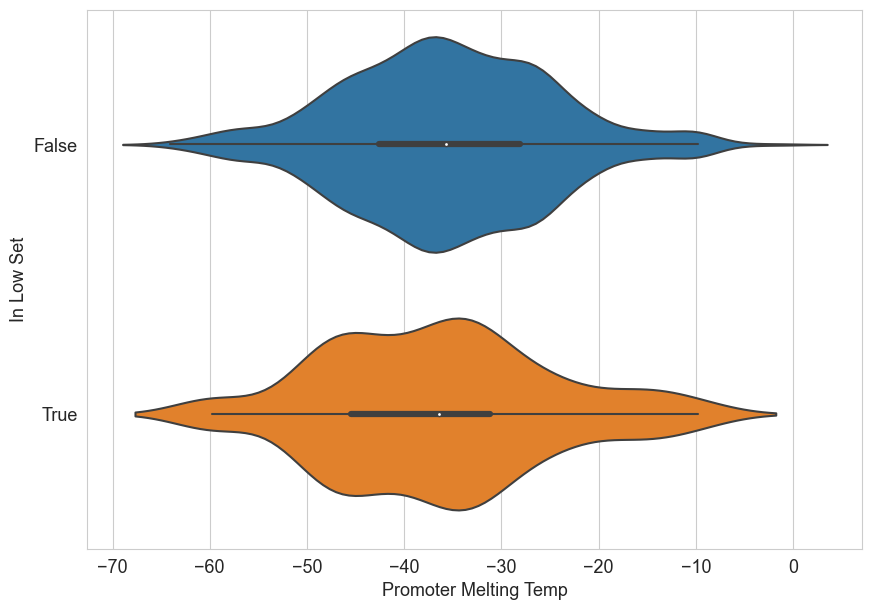

In [181]:
sns.set_style('whitegrid')

_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='tu_tm', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("Promoter Melting Temp", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

## TU Length

Text(0, 0.5, 'In Low Set')

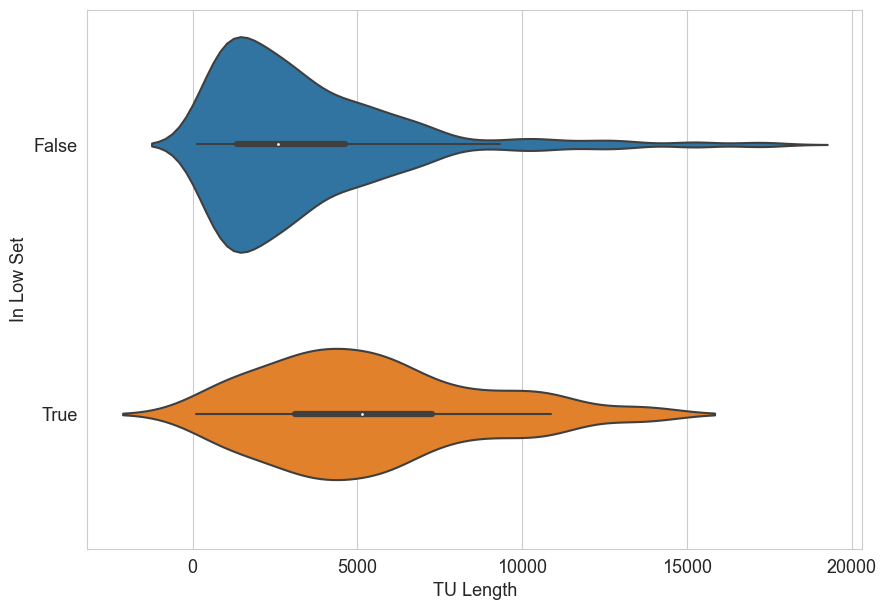

In [182]:
sns.set_style('whitegrid')

_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='tu_len', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU Length", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

## TU # of Genes

Text(0, 0.5, 'In Low Set')

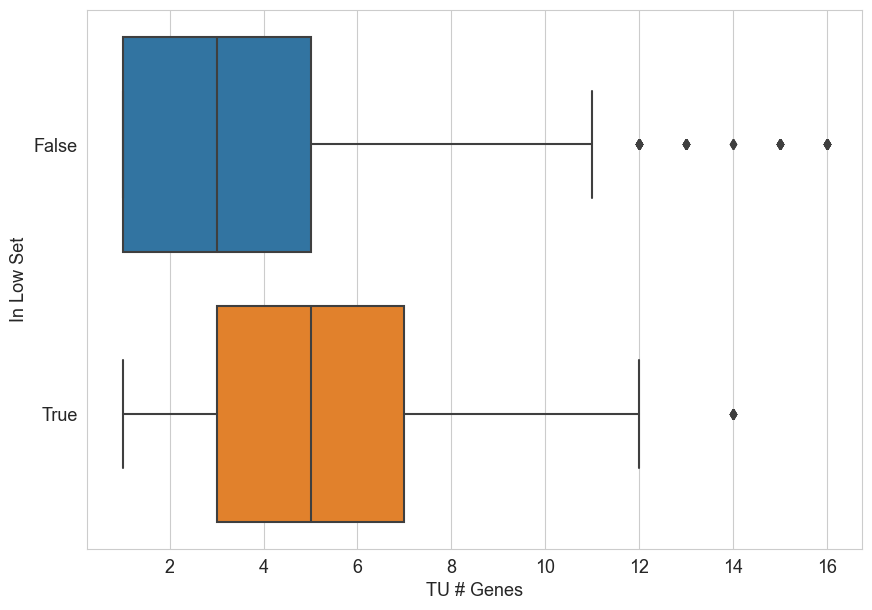

In [183]:
just_with_go = just_with_go.assign(
    tu_n_genes=pd.Series(just_with_go.index).apply(lambda bnum: max([len(mg1655._tu_to_genes[tu]) for tu in mg1655._gene_to_tus[bnum]])).values
)

sns.set_style('whitegrid')

_, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(x='tu_n_genes', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU # Genes", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

## TU GC Content

Text(0, 0.5, 'In Low Set')

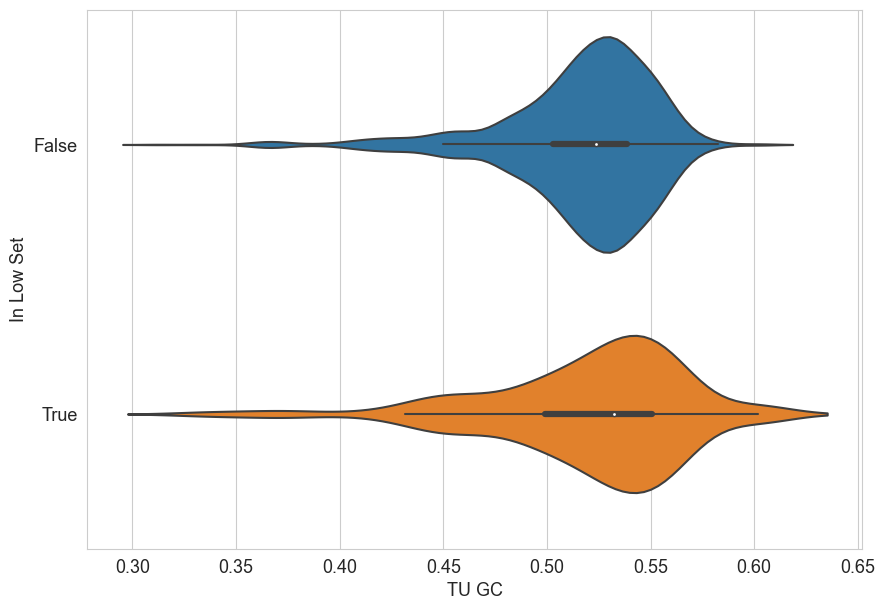

In [184]:
sns.set_style('whitegrid')

_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='tu_gc', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU GC", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

## TSS Base

<AxesSubplot: xlabel='low', ylabel='percent'>

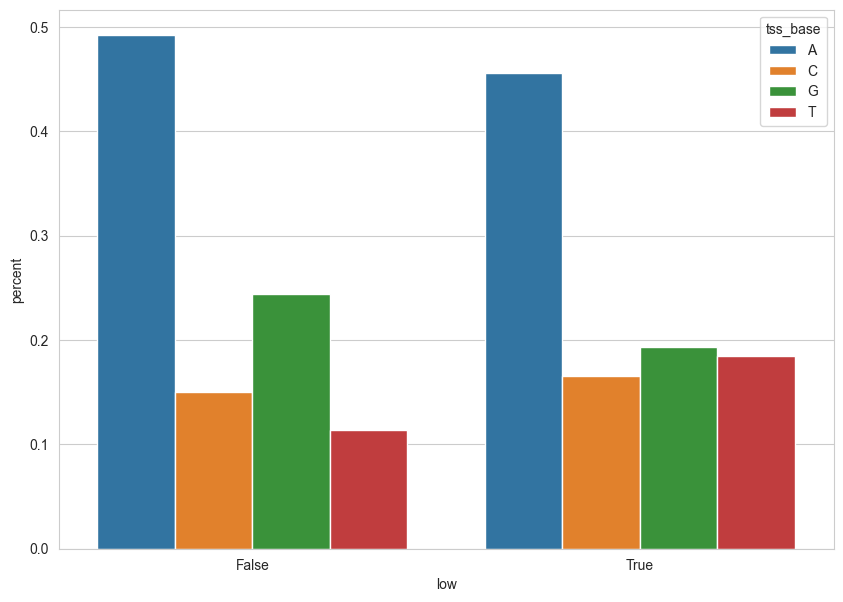

In [185]:
sns.set_style('whitegrid')

_, ax = plt.subplots(figsize=(10, 7))

pct2 = (just_with_go.groupby(['low','tss_base']).size() / just_with_go.groupby(['low']).size()).reset_index().rename({0:'percent'}, axis=1)
sns.barplot(x='low', hue='tss_base', y='percent', data=pct2)

## 5' UTR 

### Length

(0.0, 400.0)

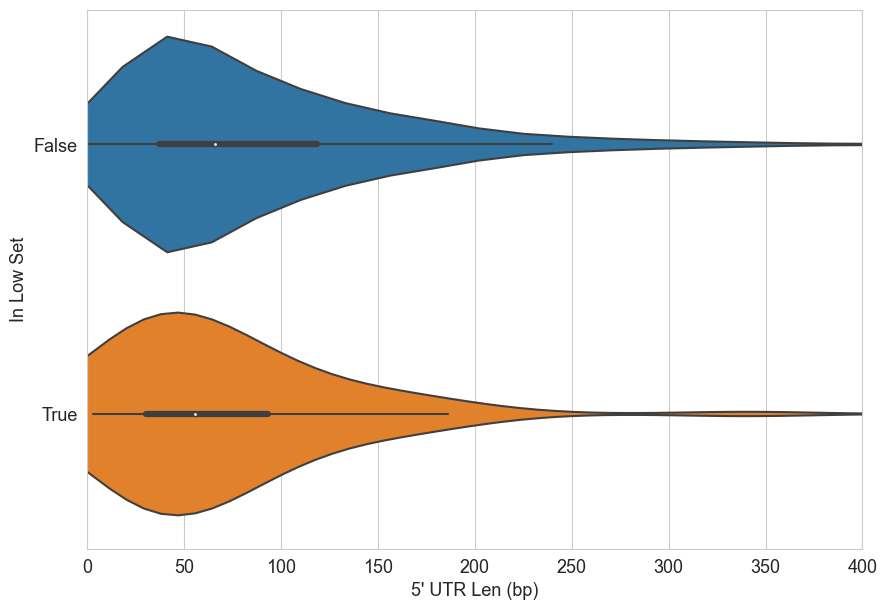

In [186]:
sns.set_style('whitegrid')

_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='utr_len', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR Len (bp)", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)
ax.set_xlim(0, 400)

### GC Content

Generate moving average GC content profiles in promoters for low and non-low

Text(0, 0.5, 'In Low Set')

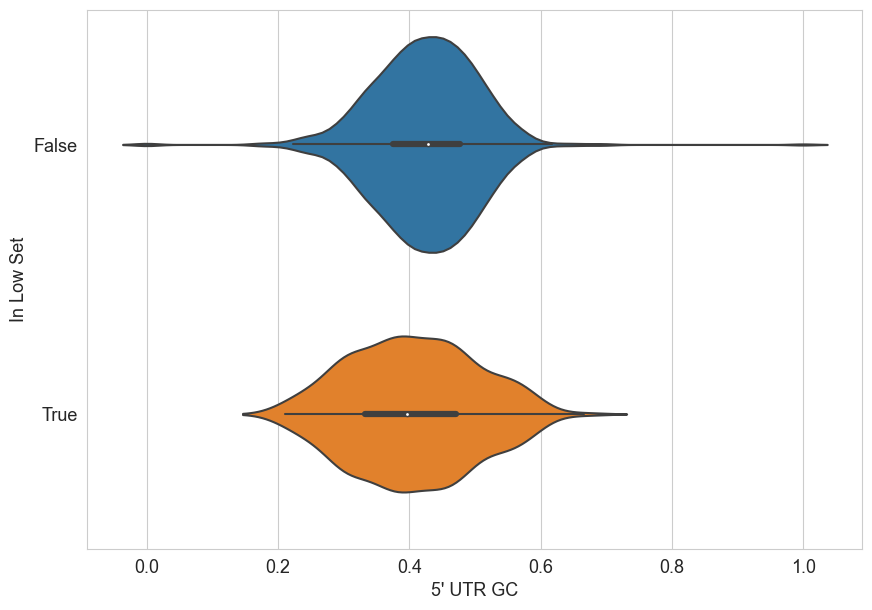

In [187]:
sns.set_style('whitegrid')

_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='utr_gc', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR GC", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

## -10/-35 Box Scores

In [188]:
sig_motifs = mg1655.create_sigma_motifs()

/Users/cam/Projects/Strainware-s/workflows_CAD/promoter_survey/../../bitome2/bitome/util.py:175: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_len, _ = mode(sequence_lens)


In [189]:
def score_box10(b10seq):
    sig_motif = sig_motifs['Sigma70']['-10'].pssm
    if len(b10seq) == len(sig_motif['A']):
        return score_motif_match(b10seq, sig_motif)
    else:
        return None
def score_box35(b35seq):
    sig_motif = sig_motifs['Sigma70']['-35'].pssm
    if len(b35seq) == len(sig_motif['A']):
        return score_motif_match(b35seq, sig_motif)
    else:
        return None
    
just_with_go = just_with_go.assign(
    box_10_score=just_with_go['box_10_seq'].apply(score_box10),
    box_35_score=just_with_go['box_35_seq'].apply(score_box35)
)

Text(0, 0.5, 'In Low Set')

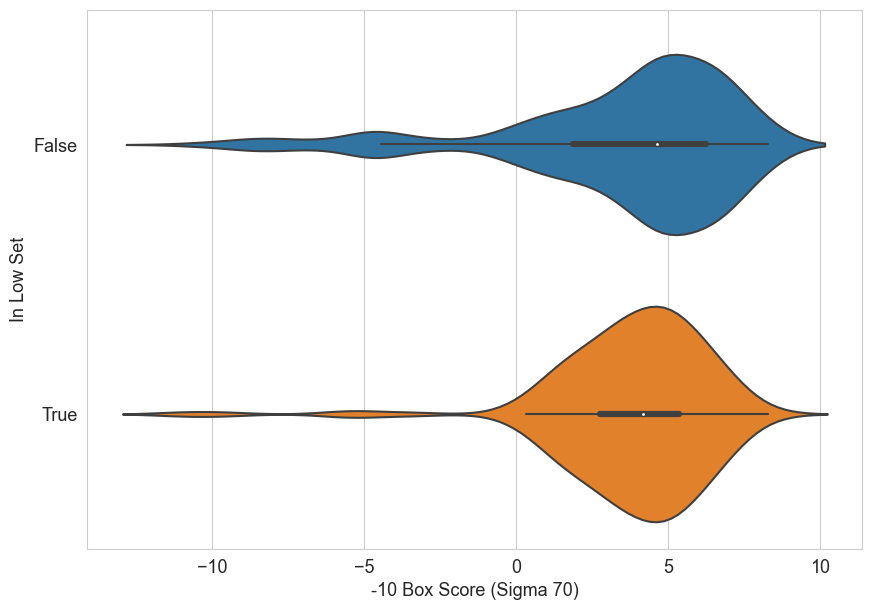

In [190]:
_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='box_10_score', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("-10 Box Score (Sigma 70)", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

Text(0, 0.5, 'In Low Set')

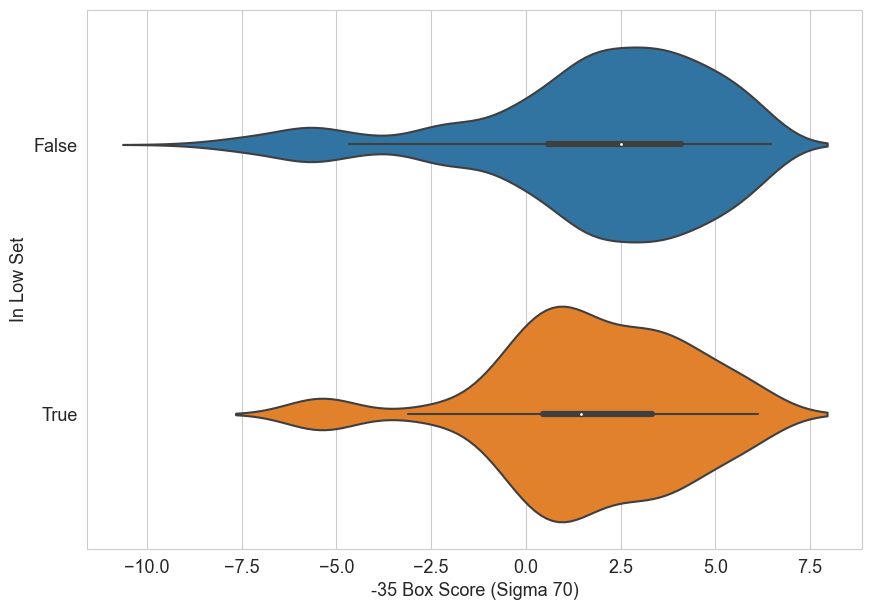

In [191]:
_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='box_35_score', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("-35 Box Score (Sigma 70)", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

## Distance to TSS

Text(0, 0.5, 'In Low Set')

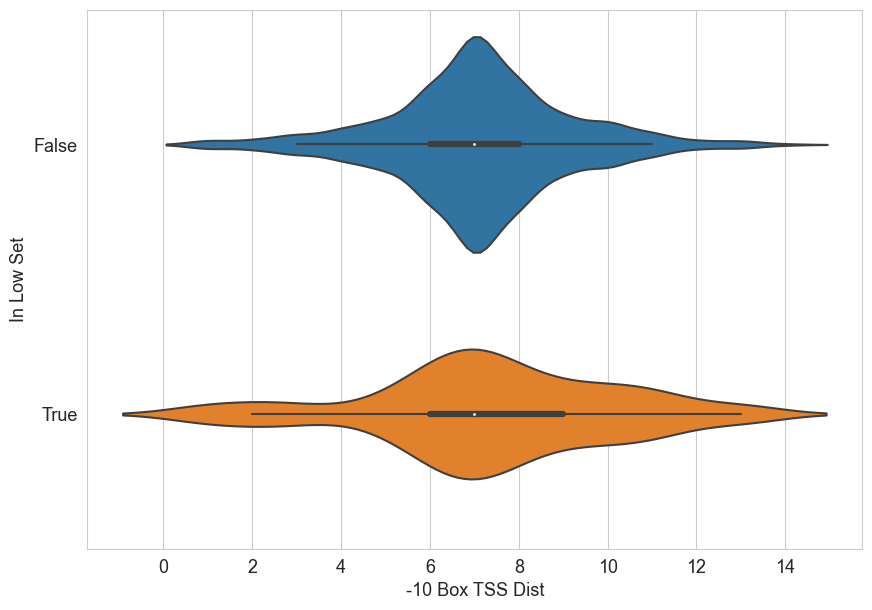

In [192]:
_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='box_10_tss_dist', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("-10 Box TSS Dist", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

Text(0, 0.5, 'In Low Set')

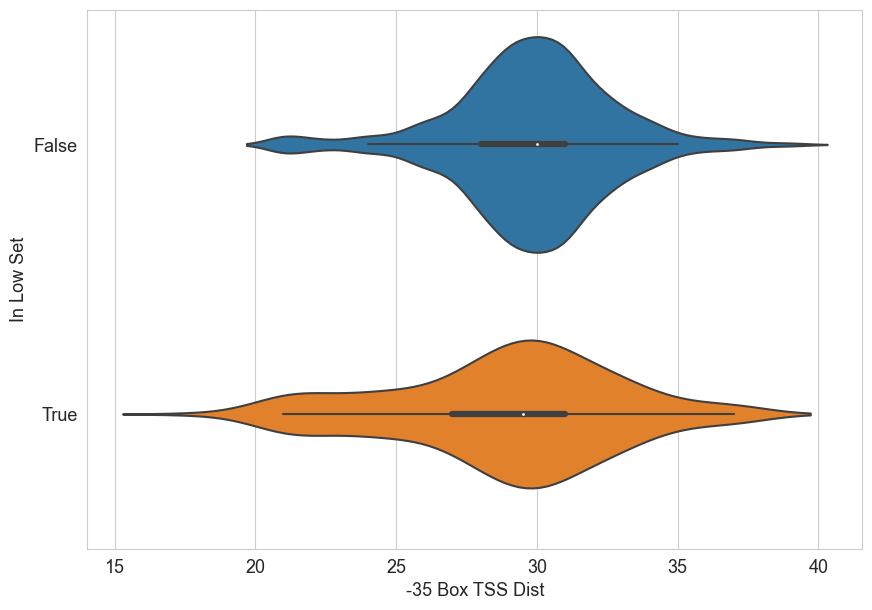

In [193]:
_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='box_35_tss_dist', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("-35 Box TSS Dist", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

## Spacer Length

Text(0, 0.5, 'In Low Set')

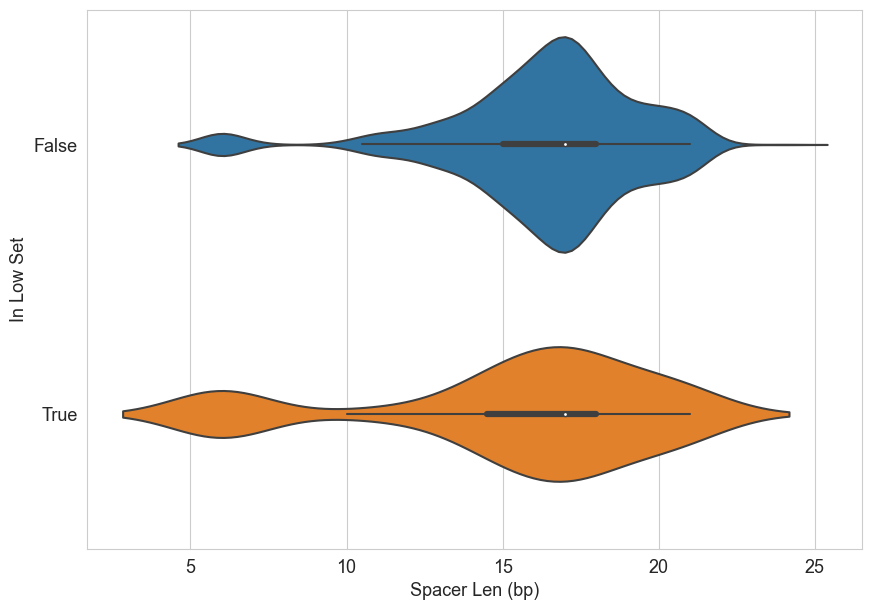

In [194]:
_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='spacer_len', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("Spacer Len (bp)", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

## Spacer GC Content

Text(0, 0.5, 'In Low Set')

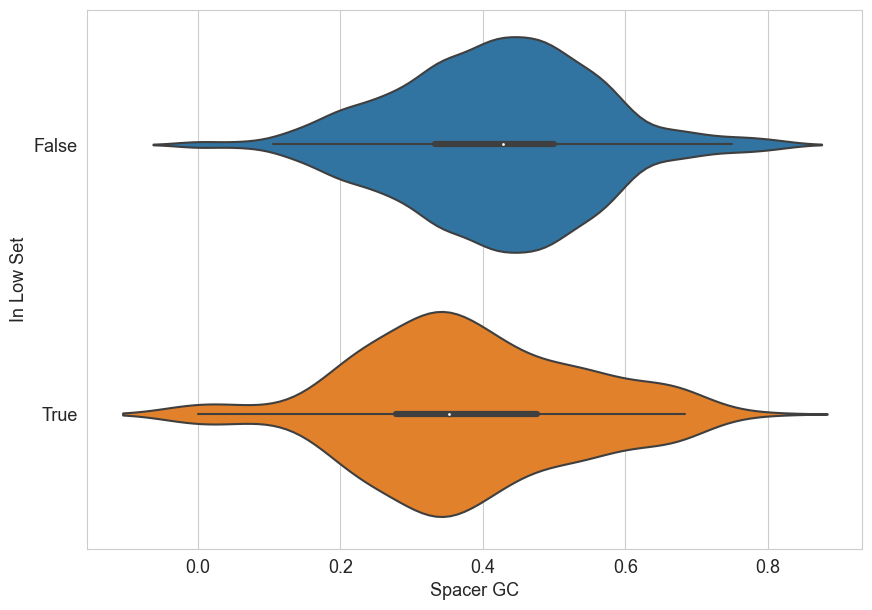

In [195]:
_, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(x='spacer_gc', y='low', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("Spacer GC", fontsize=13)
ax.set_ylabel('In Low Set', fontsize=13)

## Regulatory Effect

<AxesSubplot: xlabel='low', ylabel='percent'>

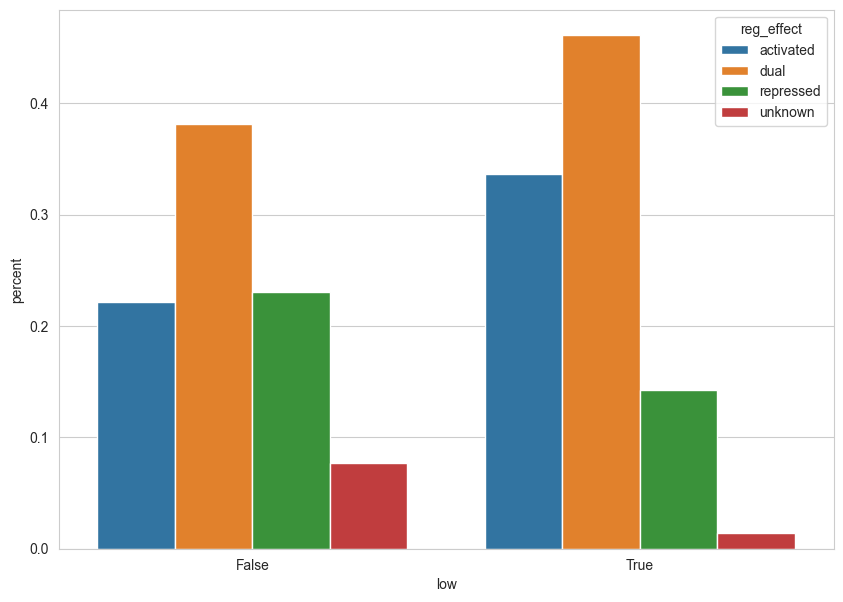

In [196]:
sns.set_style('whitegrid')

_, ax = plt.subplots(figsize=(10, 7))

pct2 = (just_with_go.groupby(['low','reg_effect']).size() / just_with_go.groupby(['low']).size()).reset_index().rename({0:'percent'}, axis=1)
sns.barplot(x='low', hue='reg_effect', y='percent', data=pct2)

# Complex vs Non-Complex

Add a binary categorial variable to annotate whether each low-expressed gene is in a "complex" or not - compare these groups in terms of inducibility
- literal complexes from EcoCyc? get from Dan
- use the "first 3 letters" rule

Text(0.5, 0, 'Max/Median Diff (log[TPM])')

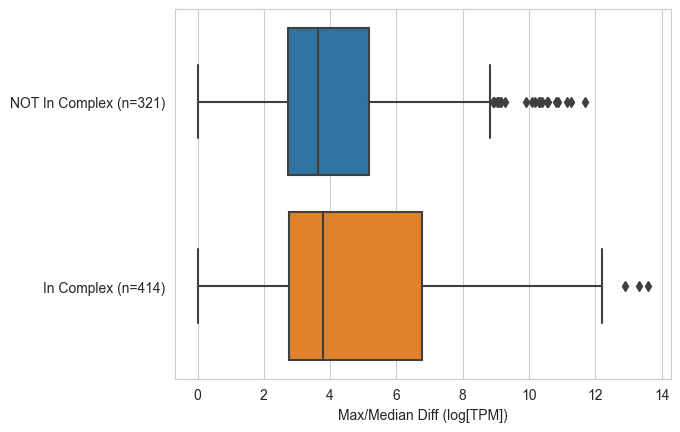

In [197]:
n_in_complex = just_low['in_complex'].sum()
n_not_in_complex = just_low.shape[0] - n_in_complex

_, ax = plt.subplots()

sns.boxplot(x='max_to_median', y='in_complex', data=just_low, orient='h')

ax.set_yticklabels([f'NOT In Complex (n={n_not_in_complex})', f'In Complex (n={n_in_complex})'])
ax.set_ylabel('')
ax.set_xlabel('Max/Median Diff (log[TPM])')

Text(0.5, 0, 'Max/Median Diff (log[TPM])')

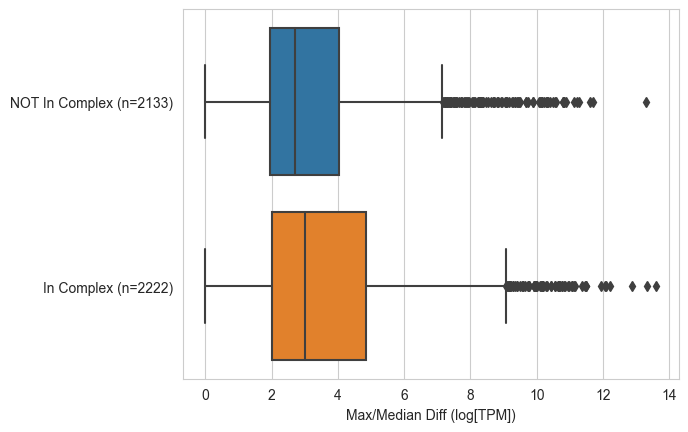

In [198]:
n_in_complex = combined_gene_table['in_complex'].sum()
n_not_in_complex = combined_gene_table.shape[0] - n_in_complex

_, ax = plt.subplots()

sns.boxplot(x='max_to_median', y='in_complex', data=combined_gene_table, orient='h')

ax.set_yticklabels([f'NOT In Complex (n={n_not_in_complex})', f'In Complex (n={n_in_complex})'])
ax.set_ylabel('')
ax.set_xlabel('Max/Median Diff (log[TPM])')

# Todo

so for this one analysis, it would be categorizing genes by their max expression, instead of median
3:15
and then looking at the bottom ranked genes there, and see if any have function
3:16
im interested in two things right now primarily, 1) how is low expression achieved (by bad promoters it looks like rather than active repression, but a more complete picture of evidence here would be nice, and 2) are genes functionally relevant at their low expression level, or just when induced
3:17
for question 2, sorting genes by their max expression instead seems helpful
New
3:17
and for question 1, somehow synthesizing all the plots around -10 -35 box goodness, regulation, etc seems helpful
3:17
does that make sense?
3:18
im kind of spitballing here, i dont have a complete picture of what would work as an analysis here

# Case Studies

## frc/oxc

In [119]:
frc_oxc_genes = combined_gene_table_w_go[combined_gene_table_w_go['gene_name'].isin(['frc', 'oxc'])]
frc_oxc_genes

,synonyms,gene_product,gene_name,regulator,DGF_strain,in_iM,left,right,strand,cog,...,box_10_ext_gc,box_35_seq,box_35_tss_dist,spacer_len,spacer_gc,tu_tm,tu_gatc,tu_n_genes,box_10_score,box_35_score
b2373,oxc;yfdU,oxalyl-CoA decarboxylase,oxc,"RpoD,YdcR,EvgA,GlaR",False,True,2490256.0,2491950.0,-1.0,E,...,0.333333,TTCTCA,30.0,16.0,0.437500,-30.031281,False,5,6.548407,3.373098
b2374,frc;yfdW,formyl-CoA transferase,frc,"RpoD,EvgA",False,True,2492004.0,2493254.0,-1.0,I,...,0.333333,TTACCA,30.5,16.5,0.336397,-27.780182,False,5,6.548407,4.015126


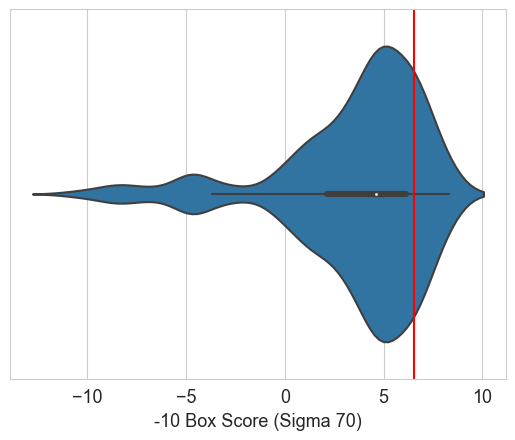

In [152]:
_, ax = plt.subplots()

sns.violinplot(x='box_10_score', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("-10 Box Score (Sigma 70)", fontsize=13)

ax.axvline(frc_oxc_genes['box_10_score'].mean(), color='red')

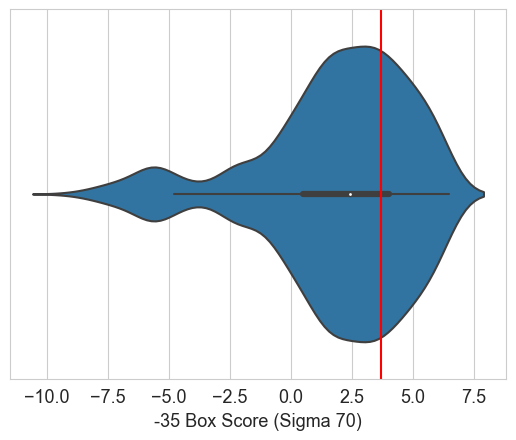

In [157]:
_, ax = plt.subplots()

sns.violinplot(x='box_35_score', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("-35 Box Score (Sigma 70)", fontsize=13)

ax.axvline(frc_oxc_genes['box_35_score'].mean(), color='red')

## phn

In [120]:
phn_genes = combined_gene_table_w_go[combined_gene_table_w_go['gene_name'].str.contains('phn')]
phn_genes

,synonyms,gene_product,gene_name,regulator,DGF_strain,in_iM,left,right,strand,cog,...,box_10_ext_gc,box_35_seq,box_35_tss_dist,spacer_len,spacer_gc,tu_tm,tu_gatc,tu_n_genes,box_10_score,box_35_score
b4092,phnP,5-phospho-alpha-D-ribosyl 1%2C2-cyclic phospha...,phnP,"RpoD,PhoB",False,False,4314344.0,4315102.0,-1.0,P,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836
b4093,phnO,aminoalkylphosphonate N-acetyltransferase,phnO,"RpoD,PhoB",False,False,4315104.0,4315538.0,-1.0,J,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836
b4094,phnN,ribose 1%2C5-bisphosphate phosphokinase,phnN,"RpoD,PhoB",False,True,4315525.0,4316082.0,-1.0,G,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836
b4095,phnM,RPnTP hydrolase,phnM,"RpoD,PhoB",False,True,4316082.0,4317218.0,-1.0,P,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836
b4096,phnL,methylphosphonate degradation complex subunit ...,phnL,"RpoD,PhoB",False,True,4317215.0,4317895.0,-1.0,P,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836
b4097,phnK,carbon-phosphorus lyase subunit PhnK,phnK,"RpoD,PhoB",False,True,4318006.0,4318764.0,-1.0,P,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836
b4098,phnJ,carbon-phosphorus lyase core complex subunit PhnJ,phnJ,"RpoD,PhoB",False,True,4318761.0,4319606.0,-1.0,P,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836
b4099,phnI,carbon-phosphorus lyase core complex subunit PhnI,phnI,"RpoD,PhoB",False,True,4319599.0,4320663.0,-1.0,P,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836
b4100,phnH,carbon-phosphorus lyase core complex subunit PhnH,phnH,"RpoD,PhoB",False,True,4320663.0,4321247.0,-1.0,P,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836
b4101,phnG,carbon-phosphorus lyase core complex subunit PhnG,phnG,"RpoD,PhoB",False,True,4321244.0,4321696.0,-1.0,P,...,0.666667,TTAGTC,28.0,21.0,0.238095,-59.724278,False,14,3.262983,0.486836


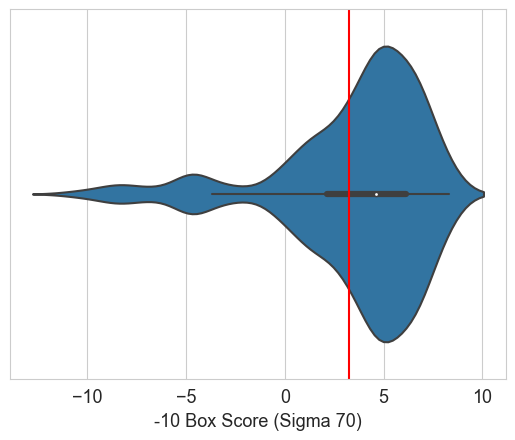

In [156]:
_, ax = plt.subplots()

sns.violinplot(x='box_10_score', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("-10 Box Score (Sigma 70)", fontsize=13)

ax.axvline(phn_genes['box_10_score'].mean(), color='red')

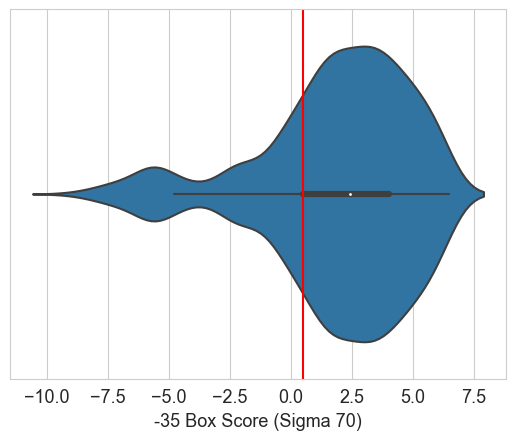

In [158]:
_, ax = plt.subplots()

sns.violinplot(x='box_35_score', data=just_with_go,orient='h', ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("-35 Box Score (Sigma 70)", fontsize=13)

ax.axvline(phn_genes['box_35_score'].mean(), color='red')

# Classifying Low

## One-Hot Encode Promoter Regions

In [200]:
one_hot_tus = mg1655.one_hot_encode_tu_promoters(n_upstream=50, n_downstream=10)
one_hot_tus.head()

,-50_A,-50_C,-50_G,-50_T,-49_A,-49_C,-49_G,-49_T,-48_A,-48_C,...,8_G,8_T,9_A,9_C,9_G,9_T,10_A,10_C,10_G,10_T
ECK120008913,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
ECK120008914,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
ECK120008915,1,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,1,0,0
ECK120008916,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,0
ECK120008917,0,0,0,1,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0


## Prepare X and y

We have to rely on TUs for which we have promoters one-hot encoded, so this workflow DOES depend on TSS annotation

We can consider that each DISTINCT TSS is resulting in a low/not-low

So let's start by having multiple sample rows per gene, one for each of its TSS/TUs

In [218]:
bnum_tu_id_to_oh = {}
bnum_tu_id_to_y = {}
for bnum, gene_row in combined_gene_table_w_go.iterrows():
    gene_tus_with_oh = [tu_id for tu_id in mg1655._gene_to_tus[bnum] if tu_id in one_hot_tus.index]
    # add a unique ID of this gene/TU combination as our key
    for tu_id_with_oh in gene_tus_with_oh:
        bnum_tu_id_to_oh[f'{bnum}__{tu_id_with_oh}'] = one_hot_tus.loc[tu_id_with_oh]
        # get the "low" annotation added early (binary category) and integerize
        bnum_tu_id_to_y[f'{bnum}__{tu_id_with_oh}'] = int(gene_row['low'])
        
# construct X and y dataframes
X = pd.DataFrame(bnum_tu_id_to_oh).T
y = pd.Series(bnum_tu_id_to_y)
# make sure our indexes are matched
assert (X.index == y.index).all()

Xy_to_try = {
    'row_per_tss': (X, y)
}

In [222]:
Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try, random_state=42)

## Train Models

In [227]:
models_to_try = {
    'RF': RandomForestClassifier(
        n_estimators=50,
        max_depth=15,
        n_jobs=4,
        class_weight='balanced',
        random_state=42
    ),
    'SVC': SVC(
        C=0.1,
        class_weight='balanced',
        random_state=42
    ),
    'LR': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
}

RF: row_per_tss__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


SVC: row_per_tss__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


LR: row_per_tss__X_raw__y_raw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.


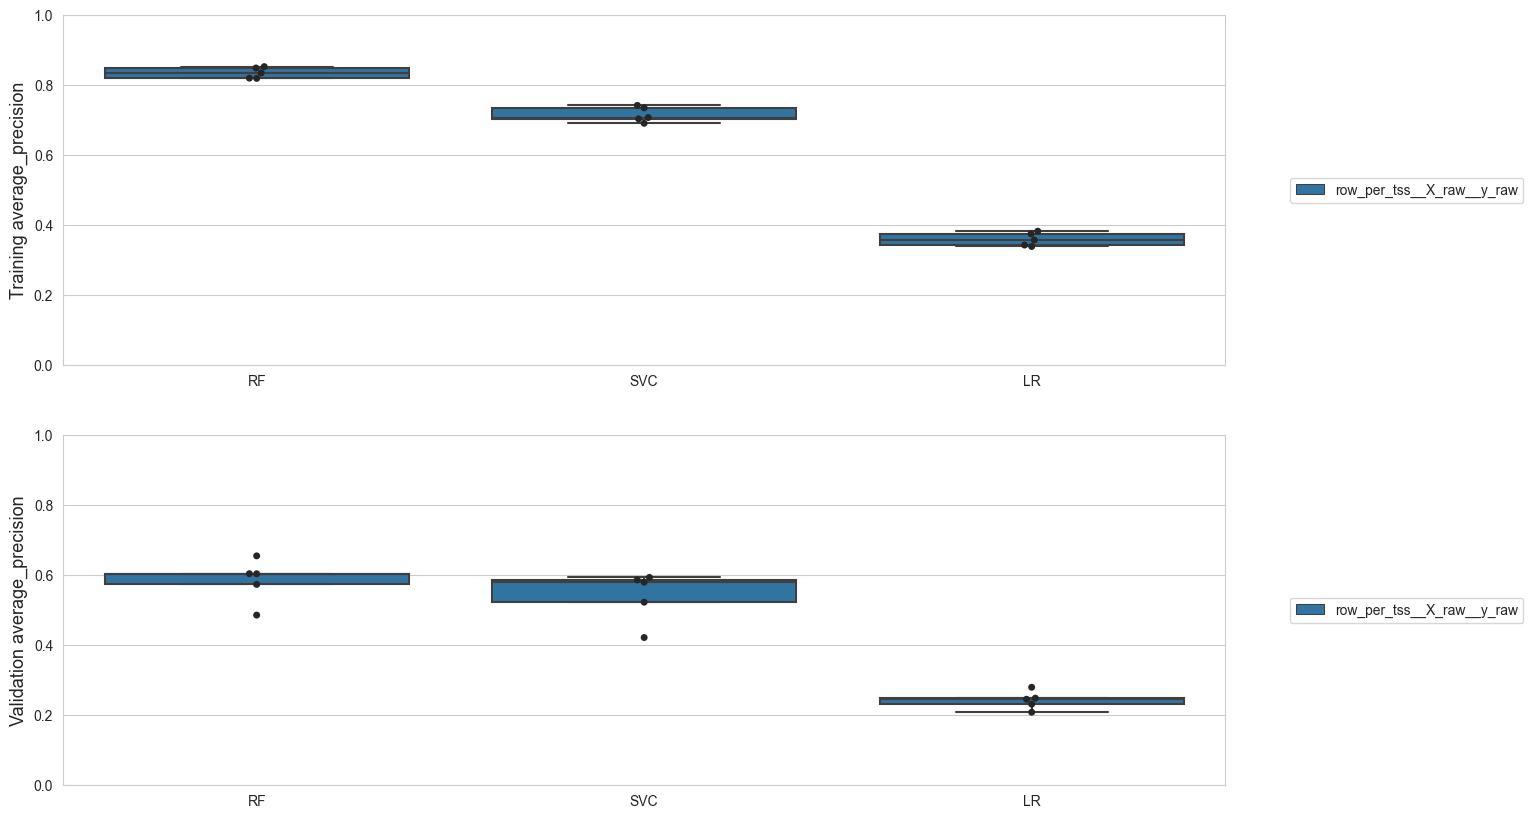

In [238]:
model_profile_df, ax_train, ax_val = profile_xy_and_models(
    Xy_train,
    models_to_try,
    scoring='average_precision',
    n_cv=5,
    verbose=True
);

## Feature Importances

Let's focus on the RF as that performs the best

<AxesSubplot: xlabel='bp from TSS', ylabel='Feature Importance'>

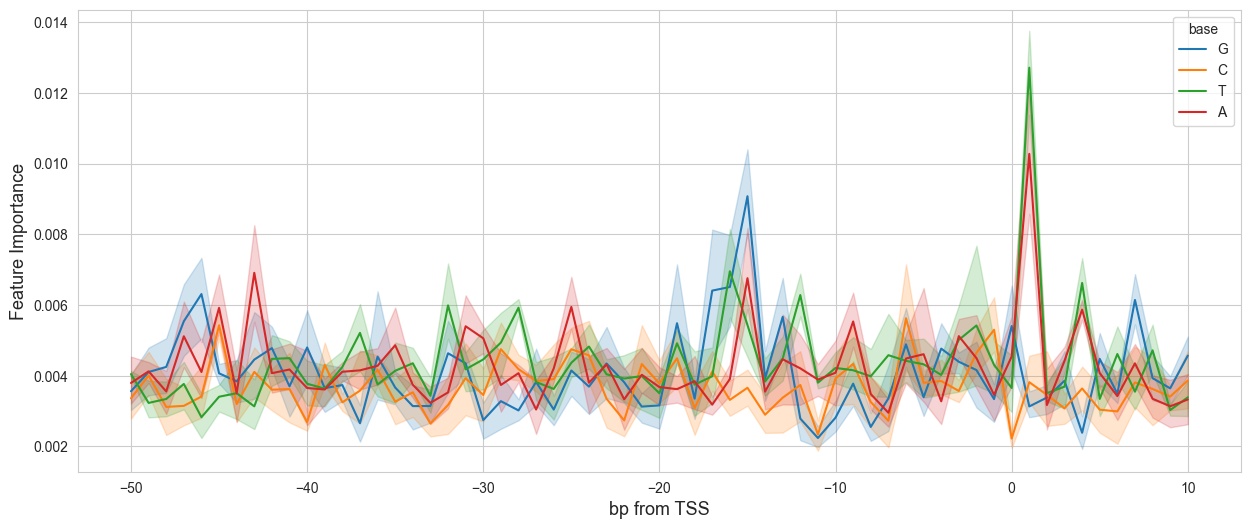

In [233]:
one_hot_feature_importance(Xy_train['row_per_tss'][0], Xy_train['row_per_tss'][1], models_to_try['RF'], scoring='average_precision', n_cv=5)

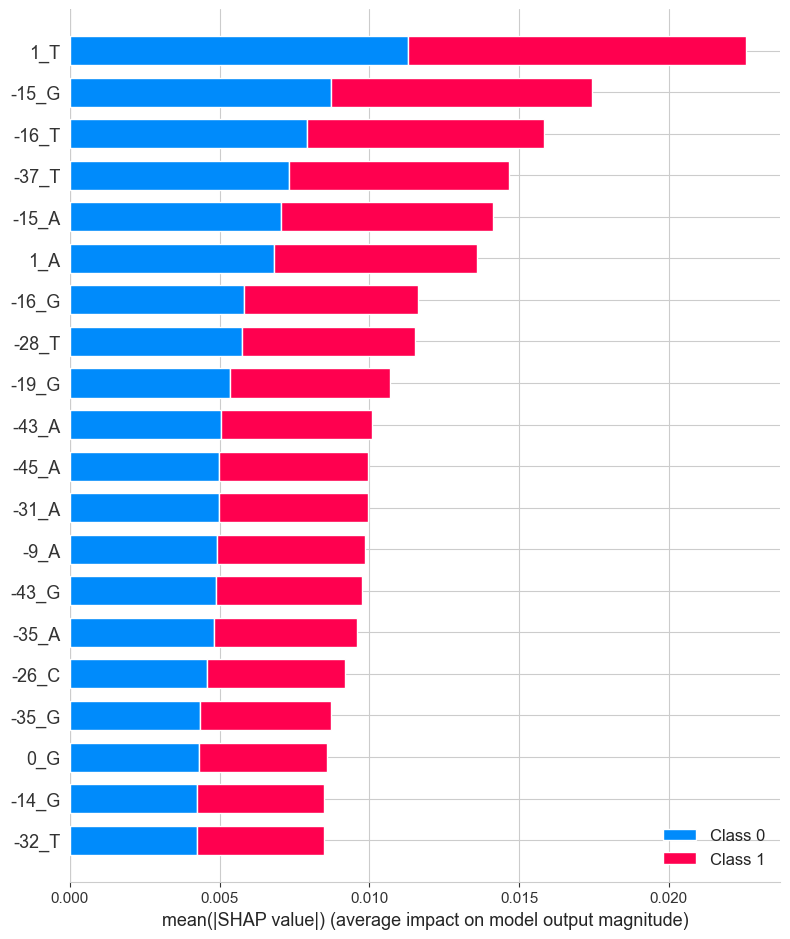

In [234]:
feature_importance(Xy_train['row_per_tss'][0], Xy_train['row_per_tss'][1], models_to_try['RF'])